# Tutorial: Bayesian Structural Time Series Model
This tutorial demonstrates modeling and running inference on various Bayesian Structural Time Series (STS) models. We demonstrate some great features of Bean Machine such as: modeling serially correlated variables, the NUTS sampler applied to a global pool of variables, and providing custom distributions for inference.

In [13]:
import sys
import os

if 'google.colab' in sys.modules and 'beanmachine' not in sys.modules:
    !pip install beanmachine

smoke_test = ('SANDCASTLE_NEXUS' in os.environ or 'CI' in os.environ)

# Problem
[Bayesian STS](https://en.wikipedia.org/wiki/Bayesian_structural_time_series) is a general class of additive models for *Time Series* series data;
$y_1, y_2, ..., y_n$ that have an associated *State Space* denoted by; $\alpha_1, \alpha_2, ..., \alpha_n$ which provides a probabilistic model for the serial correlation observed in the time series. For this tutorial, we will consider the case when $\alpha_i$ takes values in a continous state space (For a discussion of the discrete state space case, refer to this tutorial on [Hidden Markov Models](https://github.com/facebookresearch/beanmachine/blob/main/tutorials/Hidden_Markov_model.ipynb)).

Bayesian STS models typically contain, but are not limited to, some additive mixture of *Error* ($\epsilon$), *Trend* ($\mu$), and *Seasonality* ($\gamma$) components:
$$y_t = \mu_t + \gamma_t + \epsilon_t$$
Where each component is controlled either by some recursive relation of the state space, $\alpha_i$ or external covariates (i.e. Regression) such as day-of-week effects, business logic, or categories of the data.
When STS just contains just the Error, Trend, and Seasonality components, it is sometimes referred to as the ETS model. Possibly the simpliest version of STS is called the *local level* model which is where we will start our discussion after some prerequisites.

# Prerequisites
Let's code this in Bean Machine! Import the Bean Machine library, some fundamental PyTorch classes, and optionally typing for our code.

In [14]:
import logging
from typing import List

import beanmachine.ppl as bm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.distributions as dist
from beanmachine.ppl.model import RVIdentifier


logging.getLogger("beanmachine").setLevel(50)
bm.seed(111)

# Local Level Model
In this simple *local level* version of an STS, $y_t$ is the sum of our state variable $\alpha_t$ plus Gaussian Noise, $\epsilon_t$. All of the time dependency is modeled in the evolution of $\alpha_{t+1}$, which is equal to its previous time value $\alpha_t$ plus Gaussian Noise, $\eta_t$ that is independent of all $\epsilon_i$'s. This is sometimes referred to a *random walk* because at each step, noise is injected to the previous state to arrive at a new state.
To summarize, the random variables in play at this point are:
*  $\epsilon_t \stackrel{iid}{\sim} \text{Normal}(0, \sigma_\epsilon^2)$
*   $\eta_t \stackrel{iid}{\sim} \text{Normal}(0, \sigma_\eta^2)$
* $\eta_t \perp \epsilon_i, \forall i \in \{1,..., n\}$

Most STS formulations are expressed in the [state space](https://en.wikipedia.org/wiki/State-space_representation) representation, which is a coupled set of equations known as the *measurement* and *state* equations. Using our notation from before, the *local level* state space representation is:

| Name | Formula
| --- | ---
| Measurement Equation | $y_t =  \alpha_t + \epsilon_t$
| State Equation | $\alpha_{t+1} = \alpha_t + \eta_t$  

This can be represented more compactly as:
* $\alpha_{t+1} | \alpha_t \sim \text{Normal}(\alpha_{t}, \sigma_\eta^2)$
* $y_t | \alpha_t \sim \text{Normal}(\alpha_t, \sigma_e^2)$


To make our STS "Bayesian", we will assign priors to $\sigma_\epsilon$, $\sigma_\eta$, and our initial state $\alpha_1$:
* $\sigma_\epsilon \sim \text{Gamma}(\epsilon_{\text{shape}}, \epsilon_{\text{rate}})$
* $\sigma_\eta \sim \text{Gamma}(\eta_{\text{shape}}, \eta_{\text{rate}})$
* $\alpha_1 \sim \text{Normal}(a_1, p_1^2)$

We can implement this model in Bean Machine by defining random variable objects with the `@bm.random_variable` decorator. These functions behave differently than ordinary Python functions.

Semantics for `@bm.random_variable` functions:
* They must return PyTorch `Distribution` objects.
* Though they return distributions, callees actually receive samples from the distribution. The machinery for obtaining samples from distributions is handled internally by Bean Machine.
* Inference runs the model through many iterations. During a particular inference iteration, a distinct random variable will correspond to exactly one sampled value: **calls to the same random variable function with the same arguments will receive the same sampled value within one inference iteration**. This makes it easy for multiple components of your model to refer to the same logical random variable.
* Consequently, to define distinct random variables that correspond to different sampled values during a particular inference iteration, an effective practice is to add a dummy "indexing" parameter to the function. Distinct random variables can be referred to with different values for this index.
* Please see the documentation for more information about this decorator.

Note also that, compared to the statistical notation above, our implementation uses 0-indexing instead of 1-indexing.

In [15]:
class LocalLevelModel:
    def __init__(
        self,
        N: int,
        epsilon_shape: float,
        epsilon_rate: float,
        eta_shape: float,
        eta_rate: float,
        a_1: float,
        p_1: float,
    ) -> None:
        self.N = N
        self.epsilon_shape = epsilon_shape
        self.epsilon_rate = epsilon_rate
        self.eta_shape = eta_shape
        self.eta_rate = eta_rate
        self.a_1 = a_1
        self.p_1 = p_1

    @bm.random_variable
    def SigmaEpsilon(self) -> RVIdentifier:
        return dist.Gamma(self.epsilon_shape, self.epsilon_rate)

    @bm.random_variable
    def SigmaEta(self) -> RVIdentifier:
        return dist.Gamma(self.eta_shape, self.eta_rate)

    @bm.random_variable
    def Alpha(self, n: int) -> RVIdentifier:
        if n == 0:
            return dist.Normal(self.a_1, self.p_1)
        else:
            return dist.Normal(self.Alpha(n - 1), self.SigmaEta())

    @bm.random_variable
    def Y(self, n: int) -> RVIdentifier:
        return dist.Normal(self.Alpha(n), self.SigmaEpsilon())

## Data
`iclaims` is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job)from Jan 2010 - June 2018.
This dataset was curated [here](https://github.com/uber/orbit/blob/dev/orbit/utils/dataset.py#L5) and credit goes towards Uber's Orbit package.

In [16]:
def load_iclaims(end_date='2018-06-24', transform=True):
    """Load iclaims dataset
    Returns
    -------
        pd.DataFrame
    Notes
    -----
    iclaims is a dataset containing the weekly initial claims for US unemployment benefits against a few related google
    trend queries (unemploy, filling and job)from Jan 2010 - June 2018. This aims to mimick the dataset from the paper
    Predicting the Present with Bayesian Structural Time Series by SCOTT and VARIAN (2014).
    Number of claims are obtained from [Federal Reserve Bank of St. Louis] while google queries are obtained through
    Google Trends API.
    Note that dataset is transformed by natural log before fitting in order to be fitted as a multiplicative model.
    https://fred.stlouisfed.org/series/ICNSA
    https://trends.google.com/trends/?geo=US
    https://finance.yahoo.com/
    """
    url = 'https://raw.githubusercontent.com/uber/orbit/master/examples/data/iclaims_example.csv'
    df = pd.read_csv(url, parse_dates=['week'])
    df = df[df['week'] <= end_date]

    # standardize the regressors by mean; equivalent to subtracting mean after np.log
    regressors = ['trend.unemploy', 'trend.filling', 'trend.job', 'sp500', 'vix']

    # convert to float
    for col in regressors:
        df[col] = df[col].astype(float)

    if transform:
        # log transfer
        df[['claims'] + regressors] = df[['claims'] + regressors].apply(np.log)
        # de-mean
        df[regressors] = df[regressors] - df[regressors].apply(np.mean)

    return df

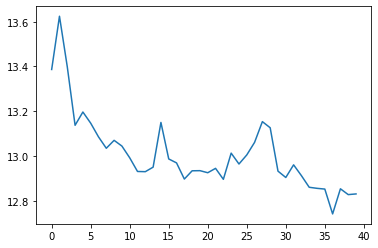

In [17]:
y_obs = torch.tensor(load_iclaims().claims.values)[:40]
plt.plot(y_obs)
plt.show()

## Inference
Inference is the process of combining _model_ with _data_ to obtain _insights_, in the form of probability distributions over values of interest. Bean Machine offers a powerful and general inference framework to enable fitting a arbitrary models to data. First lets setup our priors and instantiate our model.

In [18]:
# Prior Specification
epsilon_shape = 0.5
epsilon_rate = 1.0
eta_shape = 0.5
eta_rate = 1.0
a_1 = y_obs.mean().item()
p_1 = 1.0

# Length of our time series
N = len(y_obs)

In [19]:
# Instantiate the model and pass our length and priors
model = LocalLevelModel(
    N=N,
    epsilon_shape=epsilon_shape, 
    epsilon_rate=epsilon_rate, 
    eta_shape=eta_shape,
    eta_rate=eta_rate, 
    a_1=a_1,
    p_1=p_1 
)

Running inference consists of a few arguments:

| Name | Usage
| --- | ---
| `queries` | A list of `@bm.random_variable` targets to fit posterior distributions for.
| `observations` | The `Dict` of observations we built up, above.
| `num_samples` | Number of samples to build up distributions for the values listed in `queries`.
| `num_chains` | Number of separate inference runs to use. Multiple chains can verify inference ran correctly.

The next step is to define the queries and observations. For this particular run, we're interested in infering $\alpha$, $\sigma_\epsilon$, and $\sigma_\eta$.

In [20]:
queries = [model.Alpha(n) for n in range(model.N)] + [model.SigmaEpsilon(), model.SigmaEta()]
observations = {**{model.Y(n): y_obs[n] for n in range(model.N)}}

For this particular problem, we will use the GlobalNoUTurnSampler inference method. Bean Machine's GlobalNoUTurnSampler is the NUTS sampler you have probably used before with stan or pymc3. We have chosen to use the NUTS sampler here because it can be easily compared to other probabilistic tools.

In [21]:
num_samples = 400 if not smoke_test else 1
num_adaptive_samples = 50
all_samples = bm.GlobalNoUTurnSampler(max_tree_depth=10).infer(
    queries,
    observations,
    num_samples,
    num_chains=1,
    num_adaptive_samples=num_adaptive_samples
)

samples = all_samples.get_chain(0)

Samples collected: 100%|██████████| 450/450 [02:43<00:00,  2.75it/s]


In [22]:
alpha_samples = torch.stack([samples[model.Alpha(n)] for n in range(model.N)], dim=1)

## Visualization
We will look at the values of the samples collected for $\alpha$ and $\sigma_\epsilon$. We will take the mean of samples taken over the last 10% of the chain, and compare these to our data.

In [23]:
tail_len = num_samples // 10

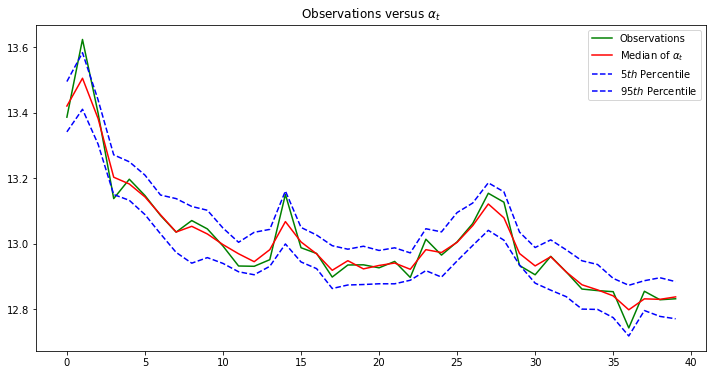

In [24]:
ppc = np.percentile(
  alpha_samples[-tail_len:].numpy(),
  q=[5, 50, 95],
  axis=0
).T

plt.figure(figsize=(12,6))
plt.plot(y_obs, label='Observations', color='green')
plt.plot(ppc[:, 1], label=r'Median of $\alpha_t$', color='red')
plt.plot(ppc[:, 0], 'b--', label=r'$5th$ Percentile')
plt.plot(ppc[:, 2], 'b--', label=r'$95th$ Percentile')
plt.title(r"Observations versus $\alpha_t$")
plt.legend()
plt.show()

It appears inference has recovered the latent states $\alpha$ very well, and is accurately representing $Y$ when sampled.

Now we investigate chain mixing by looking at the last half of the sampling chain. This type of plot is called a *trace plot* and is useful to visualize where the sampler is proposing steps.

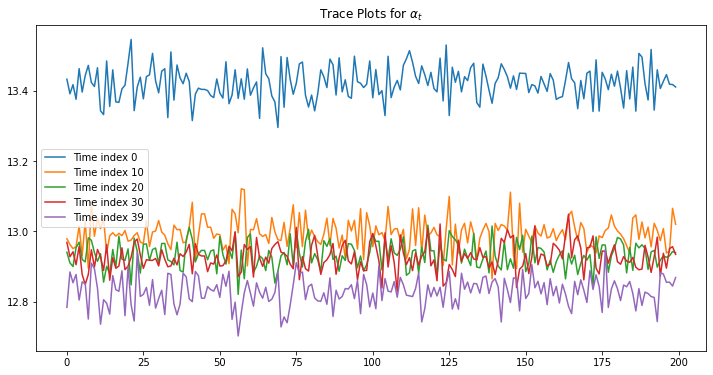

In [25]:
plt.figure(figsize=(12,6))
[plt.plot(alpha_samples[-num_samples//2:, i], label=f'Time index {i}') for i in [0, 10, 20, 30, 39]]
plt.legend()
plt.title(r"Trace Plots for $\alpha_t$")
plt.show()

We see a clear downward trend for successive time indices. This matches our intuition from the "Observations versus $\alpha_t$" plot as we see the original time series with a downward trend.

Finally we look at the uncertainty estimates as a function of time. These are the posterior samples for both $\sigma_\eta$ and $\sigma_\epsilon$.

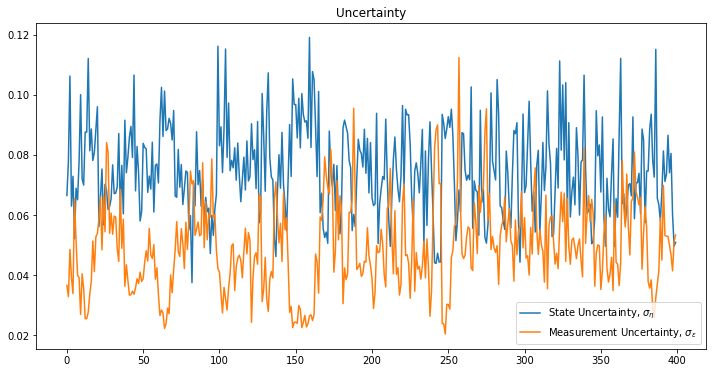

In [26]:
plt.figure(figsize=(12,6))
plt.plot(samples[model.SigmaEta()], label=r"State Uncertainty, $\sigma_\eta$")
plt.plot(samples[model.SigmaEpsilon()], label=r"Measurement Uncertainty, $\sigma_\epsilon$")
plt.title("Uncertainty")
plt.legend()
plt.show()

We see the final noise samples are quite small, reflecting the fact that the original data did not contain alot of noise.

## Posterior Likelihood Checks
One way to evaluate posterior samples is computing likelihoods of our posterior samples, and comparing these to the likelihood of the underlying data. Formally, we can compute the joint likelihood of posterior samples with the observations.

In [27]:
def log_likelihood(alpha_samples, sigma_epsilon, y_obs, N):
    ll = 0
    for n in range(N):
        ll += dist.Normal(alpha_samples[n], sigma_epsilon).log_prob(y_obs[n])
    return ll


# Iterate over the batches of samples and compute log likelihood
lls = [
    log_likelihood(alpha_samples, sigma_epsilon_sample, y_obs, N)
    for alpha_samples, sigma_epsilon_sample in zip(alpha_samples, samples[model.SigmaEpsilon()])
]

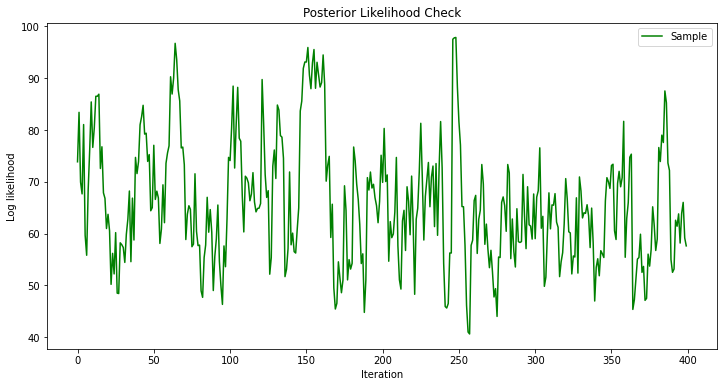

In [28]:
plt.figure(figsize=(12,6))
plt.plot(lls, label="Sample", c="g")
plt.title("Posterior Likelihood Check")
plt.ylabel("Log likelihood")
plt.xlabel("Iteration")

plt.legend()
plt.show()

From the above plot, inference appears to be fitting almost perfectly. The random variables given the observed data is exceptionally high.

# Vectorized Model
Now lets try a vectorized model by using a custom `Distribution`. We first extend pytorch's `torch.distributions.Distribution` into a vectorized version of a random walk. 
The key idea behind this implementation is that a [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) can also be expressed as a chain of iid Gaussian random variables 
that have a `cumsum` operator applied to them (thus making the "walking" behavior). Now with this `cumsum` operator, we will be able to sample entire chains in one step!


In [33]:
from torch.distributions import Distribution, constraints


class GaussianRandomWalk(Distribution):
    support = constraints.real

    def __init__(
        self,
        loc: torch.Tensor,
        scale: torch.Tensor,
        num_steps: int = 1,
        validate_args=None,
    ) -> None:
        assert isinstance(num_steps, int) and num_steps > 0, "`num_steps` argument should be an positive integer."
        self.loc = loc
        self.scale = scale
        self.num_steps = num_steps
        batch_shape, event_shape = scale.size(), torch.Size([num_steps])
        super(GaussianRandomWalk, self).__init__(batch_shape, event_shape, validate_args=validate_args)

    def sample(self, sample_shape: List = None):
        if not sample_shape:
            sample_shape = []
        assert isinstance(sample_shape, list), "`sample_shape` argument should be a list."
        shape = torch.Size(sample_shape) + self.batch_shape + self.event_shape
        loc = torch.zeros(shape)
        loc[..., 0] = self.loc
        walks = dist.Normal(loc=loc, scale=1).sample()
        return torch.cumsum(walks, axis=-1) * self.scale.unsqueeze(dim=-1)

    def log_prob(self, value):
        init_prob = dist.Normal(self.loc, self.scale).log_prob(value[..., 0])
        scale = self.scale.unsqueeze(dim=-1)
        step_probs = dist.Normal(value[..., :-1], scale).log_prob(value[..., 1:])
        return init_prob + torch.sum(step_probs, axis=-1)

    @property
    def mean(self):
        return torch.zeros(self.batch_shape + self.event_shape) + self.loc

    @property
    def variance(self):
        return torch.broadcast_to(
            self.scale.unsqueeze(dim=-1) ** 2 * torch.arange(1, self.num_steps + 1),
            self.batch_shape + self.event_shape,
        )

In our implementation above, we will now use the `sample()` and `log_prob()` functions to seamlessly integrate into Bean Machine!
Specifically, we replace the `Alpha()` function with our vectorized distribution rather than recursively calling the univariate function from before.

In [34]:
class VectorizedLocalLevelModel:
    def __init__(
        self, N: int, epsilon_shape: float, epsilon_rate: float, eta_shape: float, eta_rate: float, a_1: float
    ) -> None:
        self.N = N
        self.epsilon_shape = epsilon_shape
        self.epsilon_rate = epsilon_rate
        self.eta_shape = eta_shape
        self.eta_rate = eta_rate
        self.a_1 = a_1

    @bm.random_variable
    def SigmaEpsilon(self) -> RVIdentifier:
        return dist.Gamma(self.epsilon_shape, self.epsilon_rate)

    @bm.random_variable
    def SigmaEta(self) -> RVIdentifier:
        return dist.Gamma(self.eta_shape, self.eta_rate)

    @bm.random_variable
    def Alpha(self) -> RVIdentifier:
        return GaussianRandomWalk(loc=self.a_1, scale=self.SigmaEta(), num_steps=self.N)  # Vectorized!

    @bm.random_variable
    def Y(self) -> RVIdentifier:
        return dist.Normal(self.Alpha(), self.SigmaEpsilon())  # Vectorized!

We keep the rest of the workflow to be very similar to the unvectorized model so that we can directly compare the results. We complete inference, visualize our samples, and then compute some diagnostics of the fitted values.

In [35]:
vec_model = VectorizedLocalLevelModel(
    N=N,
    epsilon_shape=epsilon_shape,
    epsilon_rate=epsilon_rate,
    eta_shape=eta_shape,
    eta_rate=eta_rate,
    a_1=a_1
)

queries = [vec_model.Alpha(), vec_model.SigmaEpsilon(), vec_model.SigmaEta()]
observations = {**{vec_model.Y(): y_obs}}

One difference is that we now fit 4 chains (serially) in order to better investigate some diagnostic metrics. You can read more about this in the $\hat{R}$ and $ess$ cells located below.

In [36]:
num_samples = 400 if not smoke_test else 1
vec_all_samples = bm.GlobalNoUTurnSampler(max_tree_depth=10).infer(
    queries,
    observations,
    num_samples,
    num_chains=4,
    num_adaptive_samples=num_adaptive_samples
)

Samples collected: 100%|██████████| 450/450 [00:14<00:00, 30.81it/s]


Samples collected: 100%|██████████| 450/450 [00:11<00:00, 39.06it/s]















































































Samples collected: 100%|██████████| 450/450 [00:10<00:00, 44.01it/s]
































































































































































































Samples collected: 100%|██████████| 450/450 [00:12<00:00, 35.78it/s]


The speedup is quite significant using a vectorized approach! One of the main benefits of using Bean Machine is being able to incorporate this type of fast code.

In [37]:
vec_samples = vec_all_samples.get_chain(0)
vec_alpha_samples = vec_samples[vec_model.Alpha()]
vec_alpha_samples.size()

torch.Size([400, 40])

## Visualization

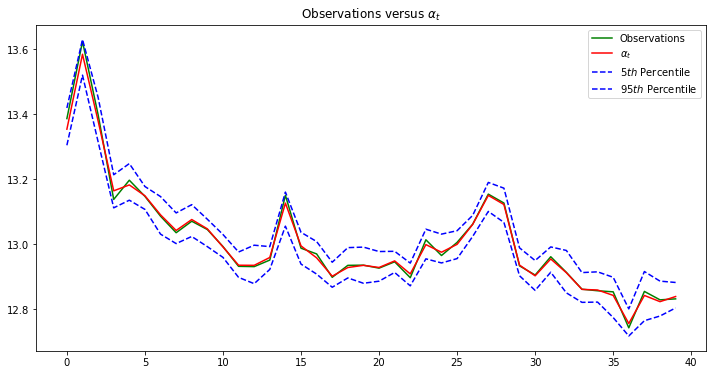

In [38]:
tail_len = num_samples // 10

vec_ppc = np.percentile(
  vec_alpha_samples[-tail_len:].numpy(),
  q=[5, 50, 95],
  axis=0
).T

plt.figure(figsize=(12,6))
plt.plot(y_obs, label='Observations', color='green')
plt.plot(vec_ppc[:, 1], label=r'$\alpha_t$', color='red')
plt.plot(vec_ppc[:, 0], 'b--', label=r'$5th$ Percentile')
plt.plot(vec_ppc[:, 2], 'b--', label=r'$95th$ Percentile')
plt.title(r"Observations versus $\alpha_t$")
plt.legend()
plt.show()

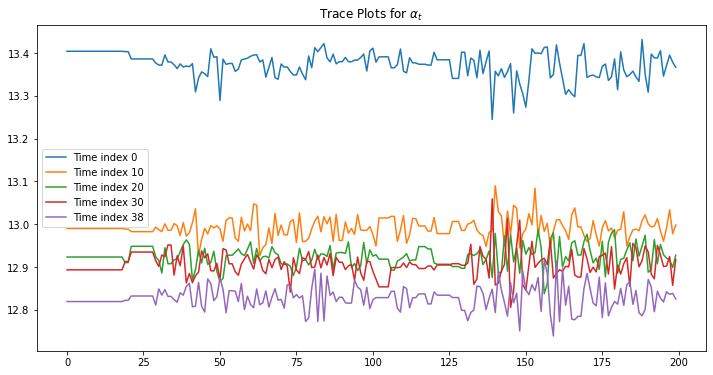

In [39]:
plt.figure(figsize=(12,6))
[plt.plot(vec_alpha_samples[-num_samples//2:, i], label=f'Time index {i}') for i in [0, 10, 20, 30, 38]]
plt.legend()
plt.title(r"Trace Plots for $\alpha_t$")
plt.show()

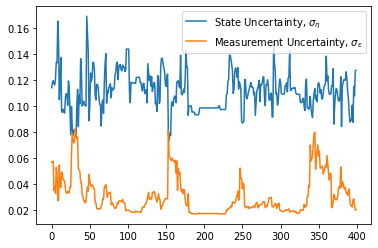

In [40]:
plt.plot(vec_samples[vec_model.SigmaEta()], label=r"State Uncertainty, $\sigma_\eta$")
plt.plot(vec_samples[vec_model.SigmaEpsilon()], label=r"Measurement Uncertainty, $\sigma_\epsilon$")
plt.legend()
plt.show()

## Diagnostics
Two important statistics to
take note of are the $\hat{R}$ (`r_hat`) and effective sample size (`ess`) values in the
below dataframe, see [Vehtari _et al_](#references).

In [41]:
import arviz as az
summary_df = az.summary(vec_all_samples.to_xarray(), round_to=3)
summary_df.T

,"SigmaEta(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[0]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[1]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[2]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[3]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[4]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[5]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[6]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[7]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[8]",...,"Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[31]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[32]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[33]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[34]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[35]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[36]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[37]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[38]","Alpha(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)[39]","SigmaEpsilon(<__main__.VectorizedLocalLevelModel object at 0x7f84880b3bd0>,)"
mean,0.111,13.374,13.589,13.395,13.159,13.192,13.146,13.086,13.042,13.066,...,12.953,12.913,12.864,12.855,12.845,12.757,12.845,12.829,12.832,0.031
sd,0.015,0.034,0.042,0.031,0.034,0.030,0.029,0.030,0.029,0.029,...,0.030,0.031,0.031,0.029,0.030,0.031,0.031,0.029,0.030,0.014
hdi_3%,0.085,13.303,13.508,13.338,13.101,13.135,13.091,13.029,12.989,13.008,...,12.898,12.856,12.808,12.806,12.785,12.701,12.782,12.774,12.777,0.012
hdi_97%,0.143,13.432,13.656,13.457,13.229,13.252,13.204,13.144,13.099,13.122,...,13.012,12.975,12.926,12.914,12.902,12.821,12.899,12.887,12.895,0.057
mcse_mean,0.001,0.002,0.008,0.001,0.004,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.003,0.001,0.001,0.001,0.004
mcse_sd,0.001,0.001,0.005,0.001,0.003,0.001,0.001,0.000,0.001,0.001,...,0.001,0.000,0.000,0.000,0.001,0.002,0.001,0.001,0.001,0.003
ess_bulk,253.645,380.494,31.401,993.541,120.332,1108.285,1342.901,1826.309,1334.649,1247.047,...,1278.118,2005.561,1914.719,2016.437,1484.570,241.219,1208.010,1507.922,1523.340,9.888
ess_tail,329.268,352.869,377.851,397.383,393.988,327.361,667.477,576.112,785.804,573.398,...,465.595,509.540,796.608,447.013,643.968,433.699,363.694,710.591,635.786,26.333
r_hat,1.016,1.046,1.086,1.057,1.033,1.049,1.037,1.065,1.044,1.033,...,1.028,1.039,1.041,1.034,1.025,1.039,1.044,1.043,1.016,1.317


### $\hat{R}$ Diagnostic

$\hat{R}$ is a diagnostic tool that measures the between- and within-chain variances. It
is a test that indicates a lack of convergence by comparing the variance between
multiple chains to the variance within each chain. If the parameters are successfully
exploring the full space for each chain, then $\hat{R}\approx 1$, since the
between-chain and within-chain variance should be equal. $\hat{R}$ is calculated as

$$
\hat{R}=\frac{\hat{V}}{W}
$$

where $W$ is the within-chain variance and $\hat{V}$ is the posterior variance estimate
for the pooled rank-traces. The take-away here is that $\hat{R}$ converges towards 1
when each of the Markov chains approaches perfect adaptation to the true posterior
distribution. We do not recommend using inference results if $\hat{R}>1.01$. More
information about $\hat{R}$ can be found in the [Vehtari _et al_](#references) paper.

### Effective sample size $ess$ diagnostic

MCMC samplers do not draw independent samples from the target distribution, which means
that our samples are correlated. In an ideal situation all samples would be independent,
but we do not have that luxury. We can, however, measure the number of _effectively
independent_ samples we draw, which is called the effective sample size. You can read
more about how this value is calculated in the [Vehtari _et al_](#references) paper,
briefly it is a measure that combines information from the $\hat{R}$ value with the
autocorrelation estimates within the chains. There are many ways to estimate effective
samples sizes, however, we will be using the method defined in the [Vehtari _et
al_](#references) paper.

The rule of thumb for `ess_bulk` is for this value to be greater than 100 per chain on
average. Since we ran four chains, we need `ess_bulk` to be greater than 400 for each
parameter. The `ess_tail` is an estimate for effectively independent samples considering
the more extreme values of the posterior. This is not the number of samples that landed
in the tails of the posterior. It is a measure of the number of effectively independent
samples if we sampled the tails of the posterior. The rule of thumb for this value is
also to be greater than 100 per chain on average.


# Heteroscedastic Model
In the previous sections, one core assumption made about the data generation process is that $\epsilon_t \stackrel{iid}{\sim} \text{Normal}(0, \sigma_\epsilon^2)$,
meaning that all of the noise in our measurement equation was sampled the same way, from the same distribution.
In the Statistics literature, this is known as *homoscedastic* noise. Instead, we could postulate a second latent random variable, $\beta_t$ that would capture
some of the serial correlation in the *noise* over time (as opposed to the level). This is referred to as a *heteroscedastic* noise. That is, we could say $\beta = g(\beta_{t - 1})$. 
One simple choice for $g(\cdot)$ is the same choice we made for $\alpha_t$, that is:
$$\beta_{t + 1} = \beta_{t} + \epsilon_{t}$$
Where the definition of $\epsilon_t$ doesn't change (or its associated prior, $\sigma_\epsilon$). Now, our model looks like this:
* $\alpha_{t+1} | \alpha_t \sim \text{Normal}(\alpha_{t}, \sigma_\eta^2)$
* $\beta_{t+1} | \beta_t \sim \text{Normal}(\beta_{t}, \sigma_\epsilon^2)$
* $y_t | \alpha_t \sim \text{Normal}(\alpha_t, f(\beta_t^2))$

So that as the process goes on, the noise can now "walk" just like our level from before. The last detail to attend to
is the function $f(\cdot)$. Since the `Normal` distribution's `scale` parameter lives in $\mathbb R^+$, we need to apply a smooth
function to achieve this. One nice candidate is [torch.nn.Softplus()](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html)
which is a smooth approximation to the `Relu` function. We will use the `@bm.functional` wrapper to accomplish this deterministic mapping, 
creating an intermediate random variable called `Scale`.

One last note, we are now computing uncertainty of both our level ($\alpha_t$),
our noise ($\beta_t$), and our observations $y_t$. These "types" of uncertainty can be broadly cast into two 
seperate categories: *aleatoric* uncertainty and *epistimic* uncertainty. A quick read on the topic can be found 
[here](https://en.wikipedia.org/wiki/Uncertainty_quantification) but the gist is that aleatoric is the
data uncertainty, and measures the inherent randomness in the observed data. This type of uncertainty would be appropriate
for forming *prediction* intervals for new data. Epistimic uncertainty on the other hand, measures the uncertainty in a *parameter* estimate.
So here, we are estimating the conditional mean ($\alpha_t$) and conditional variance ($f(\beta_t)^2$). This type of 
uncertainty is useful for forming *credible* intervals. We will visualize and explore this detail more later, so feel free to read on!

In [42]:
class HeteroLocalLevelModel:
    def __init__(
        self,
        N: int,
        epsilon_shape: float,
        epsilon_rate: float,
        eta_shape: float,
        eta_rate: float,
        a_1: float,
    ) -> None:
        self.N = N
        self.epsilon_shape = epsilon_shape
        self.epsilon_rate = epsilon_rate
        self.eta_shape = eta_shape
        self.eta_rate = eta_rate
        self.a_1 = a_1
        self.p_1 = p_1

    @bm.random_variable
    def SigmaEpsilon(self) -> RVIdentifier:
        return dist.Gamma(self.epsilon_shape, self.epsilon_rate)

    @bm.random_variable
    def SigmaEta(self) -> RVIdentifier:
        return dist.Gamma(self.eta_shape, self.eta_rate)

    @bm.random_variable
    def Alpha(self) -> RVIdentifier:
        return GaussianRandomWalk(loc=self.a_1, scale=self.SigmaEta(), num_steps=self.N)  # Vectorized!

    @bm.random_variable
    def Beta(self) -> RVIdentifier:
        return GaussianRandomWalk(loc=torch.Tensor([0.0]), scale=self.SigmaEpsilon(), num_steps=self.N)  # Vectorized!

    @bm.functional
    def Scale(self) -> RVIdentifier:
        return torch.nn.Softplus()(self.Beta())

    @bm.random_variable
    def Y(self) -> RVIdentifier:
        return dist.Normal(self.Alpha(), self.Scale())

In [43]:
hetero_model = HeteroLocalLevelModel(
    N=N,
    epsilon_shape=epsilon_shape,
    epsilon_rate=epsilon_rate,
    eta_shape=eta_shape,
    eta_rate=eta_rate,
    a_1=a_1
)

queries = [hetero_model.Alpha(), hetero_model.Scale()]
observations = {**{hetero_model.Y(): y_obs}}
num_samples = 400 if not smoke_test else 1
hetero_all_samples = bm.GlobalNoUTurnSampler().infer(
    queries, observations, num_samples, num_chains=1, num_adaptive_samples=num_adaptive_samples * 3
)

Samples collected: 100%|██████████| 550/550 [01:35<00:00,  5.78it/s]


In [44]:
hetero_samples = hetero_all_samples.get_chain(0)
hetero_alpha_samples = hetero_samples[hetero_model.Alpha()]
hetero_scale_samples = hetero_samples[hetero_model.Scale()]

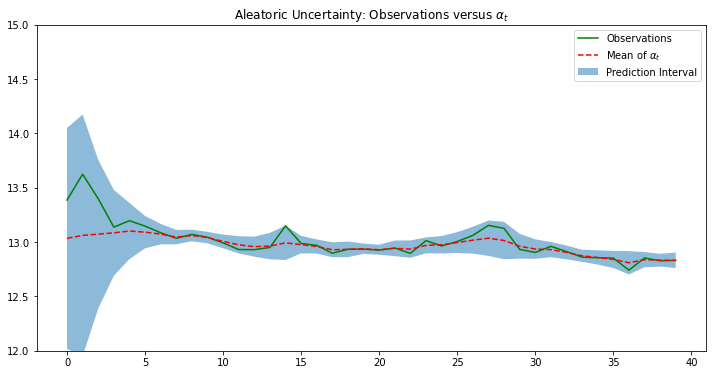

In [45]:
loc = hetero_alpha_samples[-tail_len:].mean(0)
scale = hetero_scale_samples[-tail_len:].mean(0)
aleatoric = dist.Normal(loc, scale)
quantiles = aleatoric.icdf(torch.Tensor([0.05, 0.95]).unsqueeze(-1))

plt.figure(figsize=(12, 6))
plt.plot(y_obs, label="Observations", color="green")
plt.plot(loc, "r--", label=r"Mean of $\alpha_t$")
plt.fill_between(torch.arange(N), quantiles[0, ...], quantiles[1, ...], alpha=0.5, label="Prediction Interval")
plt.ylim(12, 15)
plt.title(r"Aleatoric Uncertainty: Observations versus $\alpha_t$")
plt.legend()
plt.show()

As seen from the plot, the mean of $\alpha_t$ appears much smoother than before. The reason is because by fitting both the *location* and *scale* of $\text{Normal}(\alpha_t, f(\beta_t))$, we enable a more flexible fit to the data (contrast this from before when `SigmaEpsilon()` was a single parameter that was supposed to estimate the noise for the entire sequence!). For example, when the data becomes more noisy, our model can simply widen $\beta_t$ without overcorrecting $\alpha_t$ which ensures smoother connections with later points. Thus, the model is able to more accurately detect a *latent* trend while still learning an evolving (*heteroskedastic*) noise level. This is an example of learning the *aleatoric* uncertainty (inherent randomness), which we display with a *prediction* interval. 

Now we show the other type of uncertainty, epistemic.

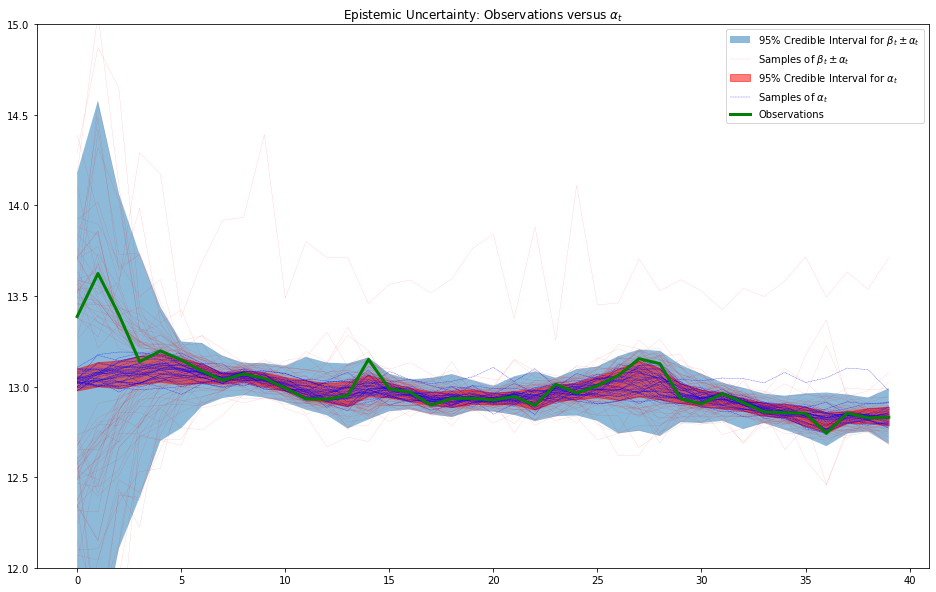

In [64]:
epistemic_alpha = np.quantile(hetero_alpha_samples[-tail_len:].detach().numpy(), [0.05, 0.95], axis=0)

plt.figure(figsize=(16, 10))
# CI for Beta
plt.fill_between(
    torch.arange(N), 
    np.quantile((hetero_alpha_samples[-tail_len:] - hetero_scale_samples[-tail_len:]).detach().numpy(), 0.05, 0),
    np.quantile((hetero_alpha_samples[-tail_len:] + hetero_scale_samples[-tail_len:]).detach().numpy(), 0.95, 0), 
    alpha=0.5,
    label=r"95% Credible Interval for $\beta_t \pm \alpha_t$"
)
# Beta samples
plt.plot(hetero_alpha_samples[-tail_len:].T - hetero_scale_samples[-tail_len:].T, 'r--', linewidth=0.1)
plt.plot(hetero_alpha_samples[-tail_len:].T + hetero_scale_samples[-tail_len:].T, 'r--', linewidth=0.1)
plt.plot(hetero_alpha_samples[-tail_len:].T[0] + hetero_scale_samples[-tail_len:].T[0], 'r--', label=r'Samples of $\beta_t \pm \alpha_t$', linewidth=0.1)
# CI for Alpha
plt.fill_between(
    torch.arange(N), 
    epistemic_alpha[0, ...], 
    epistemic_alpha[1, ...], 
    alpha=0.5, 
    color='red', 
    label=r"95% Credible Interval for $\alpha_t$"
)
# Samples for Alpha
plt.plot(hetero_alpha_samples[-tail_len:].T, 'b--', linewidth=0.3)
plt.plot(hetero_alpha_samples[-tail_len:].T[0, ...], 'b--', label=r'Samples of $\alpha_t$', linewidth=0.3)
plt.plot(y_obs, label="Observations", color="green", linewidth=3)
plt.ylim(12, 15)
plt.title(r"Epistemic Uncertainty: Observations versus $\alpha_t$")
plt.legend()
plt.show()

Before we showed how there was uncertainty in where the data will be observed next (aleatoric) which we encoded with a distribution $\text{Normal}(\alpha_t, \beta_t)$ made up of point estimates of parameters `Alpha` and `Beta`. But remember, these parameters themselves are estimated from the data and have their own uncertainty! This is the *epistemic* uncertainty. Rather than show the point estimates, above we show a 95% credible interval for both $\alpha_t$ and $\beta_t$ at each time index. Note that $\beta_t$'s uncertainty is superimposed (added and subtracted) on top of $\alpha_t$ since it is measured in different units. It is now clear that by integrating in the *epistemic* uncertainty into our parameter estimates for the *aleatoric* uncertainty, the corresponding prediction intervals would be a great deal wider (which is often the case).

In either case, by using Bean Machine we can handle epistemic *and* aleatoric uncertainty quite easily with only about 1-2 lines of extra code! 